# Experiments
### Notebook to run experiments on the data supplied by the chair of functional materials at Saarland University

## Experiment: 
### Run RAFT optical flow model on the data
<font size="5"> 
In this experiment we will run the RAFT optical flow model on the data to see how well it performs compared to classical optical flow methods.
</font>

### Results:
<font size="5"> 
RAFT seems to fail completely on the data, this might be due to the fact that the data is not similar to the data the model was trained on.
</font>

In [31]:
import torch
import numpy as np
from tqdm import tqdm
import cv2
from raft.utils import get_video_frames, plot_frames, preprocess

In [3]:
video_path = "videos/DoubleC-shape/double_c_shape.mp4"
frames = get_video_frames(video_path)

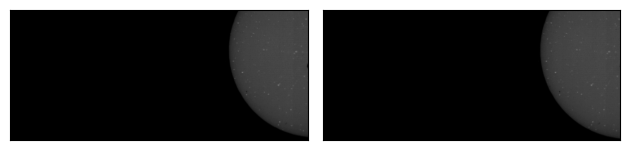

In [4]:
# Change the numbers in frames to see different images.
img_batch = torch.stack([frames[50], frames[51]])
plot_frames(img_batch)

In [5]:
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow.raft import Raft_Large_Weights

model = raft_large(weights=Raft_Large_Weights.C_T_V2)
model = model.eval()

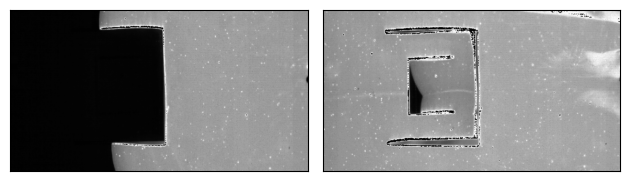

In [6]:
img1_batch: torch.Tensor = preprocess(torch.stack([frames[130], frames[220]]))
img2_batch: torch.Tensor = preprocess(torch.stack([frames[131], frames[221]]))

plot_frames(img1_batch)

In [7]:
predicted_flows: torch.Tensor = model(img1_batch, img2_batch)[-1]

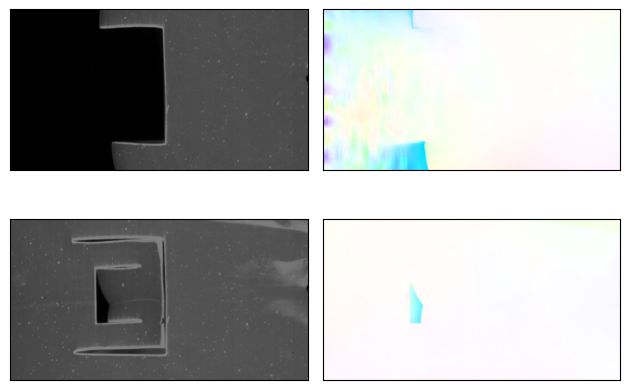

In [13]:
from torchvision.utils import flow_to_image
flow_images = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = (img1_batch + 1.) / 2.

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_images)]
plot_frames(grid) 

Save a video of the optical flow over time

In [32]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter('output.mp4', fourcc, 30.0, (520, 960))
for i, flow in tqdm(enumerate(frames[:-1])):
    frame1 = preprocess(frames[i]).unsqueeze(0)
    frame2 = preprocess(frames[i+1]).unsqueeze(0)
    predicted_flow = model(frame1, frame2)[-1]
    output_array = predicted_flow.detach().cpu().numpy()
    output_array = ((output_array - output_array.min()) * (255.0 / (output_array.max() - output_array.min()))).astype(np.uint8)
    output_image = cv2.cvtColor(output_array, cv2.COLOR_GRAY2BGR)
    video_writer.write(output_image)
video_writer.release()

0it [00:00, ?it/s]

230it [17:18,  4.52s/it]


In [26]:
preprocess(frames[i]).unsqueeze(0).shape

torch.Size([1, 3, 520, 960])

In [20]:
predicted_flows.shape

torch.Size([2, 2, 520, 960])